Copyright Preferred Computational Chemistry, Inc as contributors to Matlantis contrib project

# Structure search using CrySPY's ASE interface and PFP

In this guide, we will explore crystal structures for binary compounds using evolutionary algorithms with the ASE interface in CrySPY and PFP.

### Package Installation

Install the required packages: pfp-api-client, matlantis-features, and cryspy.

As of writing, the most current edition of CrySPY is [v1.2.0](https://github.com/Tomoki-YAMASHITA/CrySPY/releases/tag/v1.2.0).

In [1]:
# ! pip install pfp-api-client
# ! pip install matlantis-features
# ! pip install csp-cryspy

### 1. Import Packages and Specify Output Directory

Specify the output directory by `results` parameter

In [2]:
import os
import subprocess
import time
import pandas as pd
import matplotlib.pyplot as plt

from ase.io import read
from ase.spacegroup.symmetrize import FixSymmetry
from ase.geometry.analysis import Analysis

from pymatgen.io.cif import CifWriter
from pymatgen.io.ase import AseAtomsAdaptor

from matlantis_features.features.common.opt import LBFGSASEOptFeature
from matlantis_features.utils.calculators import pfp_estimator_fn

from pfp_api_client.pfp.estimator import EstimatorCalcMode

from utils import check_log_for_string 

os.makedirs("./output/calc_in", exist_ok = True)

### 2. Creating Input Files

To use CrySPY through its ASE interface, you need to prepare three input files:`cryspy.in`, `calc_in/ase_in.py_1`, `calc_in/job_cryspy`.  Please refer to [the official documentation](https://tomoki-yamashita.github.io/CrySPY_doc/tutorial/random/ase/index.html) for further details

#### cryspy.in

`cryspy.in` is a file used to set the calculation conditions for CrySPY. An example of the settings is provided below. This notebook will run calculations for a binary compound, CaSi, consisting of 8 atoms. To ensure a realistic structure, a minimum distance between atoms has been established.

- `atype = Ca Si` # Specifies Atom 1 and Atom 2
- `mindist_1 = 2.5 2.0` # Minimum distance between Atom 1 and Atom 1, and Atom 1 and Atom 2
- `mindist_2 = 2.0 2.0` # Minimum distance between Atom 2 and Atom 1, and Atom 2 and Atom 2

Settings for the evolutionary algorithm are defined in the [EA] block. Refer to [a paper](
https://www.tandfonline.com/doi/full/10.1080/27660400.2021.1943171) related to CrySPY for methods of structure generation using the evolutionary algorithm.

Executing the following cell will create cryspy.in.

In [3]:
%%writefile ./output/cryspy.in
[basic]
algo = EA
calc_code = ASE
tot_struc = 50
nstage = 1
njob = 10
jobcmd = bash
jobfile = job_cryspy

[structure]
natot = 8
atype = Ca Si
nat =  4 4
mindist_1 = 2.5 2.0
mindist_2 = 2.0 2.0

[ASE]
ase_python = ase_in.py

[EA]
n_pop = 30
n_crsov = 10
n_perm = 10
n_strain = 5
n_rand = 5
n_elite = 10
n_fittest = 15
fit_reverse = False
slct_func = TNM
t_size = 5
sigma_st = 0.10
crs_lat = equal
nat_diff_tole = 2
ntimes = 1
maxcnt_ea = 50
maxgen_ea = 5

[option]

Overwriting ./output/cryspy.in


#### calc_in/ase_in.py_1

This file contains the implementation of the program for relaxing structures generated by CrySPY using PFP. The calculation mode is set to `CRYSTAL_U0`. You are free to modify the file according to your needs. Special structures may form when the three lattice vectors approach the same plane. Structures with lattice vector angles below a certain threshold have zero energy.

In [4]:
%%writefile ./output/calc_in/ase_in.py_1
import os
import numpy as np

from ase.spacegroup.symmetrize import FixSymmetry
from ase.io import read, write

from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import EstimatorCalcMode

from matlantis_features.features.common.opt import LBFGSASEOptFeature
from matlantis_features.utils.calculators import pfp_estimator_fn

# ---------- input structure
# CrySPY outputs 'POSCAR' as an input file in work/xxxxxx directory
atoms = read('POSCAR', format='vasp')

# ---------- setting and run    
def filter_structure(atoms_cell):
    n = np.cross(atoms_cell[0], atoms_cell[1])
    c = atoms_cell[2]
    # Calculate the dot product between c and n
    dot_product = np.dot(c, n)

    # Calculate the magnitudes of c and n
    mag_c = np.linalg.norm(c)
    mag_n = np.linalg.norm(n)

    # Calculate the cosine of the angle theta
    cos_theta = dot_product / (mag_c * mag_n)

    # Calculate the angle theta in radians
    theta_rad = np.arccos(np.clip(cos_theta, -1, 1))

    # Convert theta from radians to degrees if needed
    theta_deg = np.degrees(theta_rad)

    # print("Theta (in degrees):", np.abs(90 - theta_deg))

    if np.abs(90 - theta_deg) > 25.0:
        return True
    else:
        return False

if filter_structure(atoms.cell):
    atoms.set_constraint([FixSymmetry(atoms)])
    opt = LBFGSASEOptFeature(n_run=1000,
                             filter=True,
                             estimator_fn=pfp_estimator_fn(
                                 model_version="v5.0.0",
                                 calc_mode=EstimatorCalcMode.CRYSTAL_U0,
                             ),
                            )
    result_opt = opt(atoms)
    e = result_opt.atoms.ase_atoms.get_total_energy()
    with open('log.tote', mode='w') as f:
        f.write(str(e))

    write('CONTCAR', result_opt.atoms.ase_atoms, format='vasp')

else:
    with open('log.tote', mode='w') as f:
        f.write(str(0.00))

    write('CONTCAR', atoms, format='vasp')

#### calc_in/job_cryspy

This is a script for executing the ASE interface.

In [5]:
%%writefile ./output/calc_in/job_cryspy
#!/bin/sh

# ---------- ASE
python ase_in.py

# ---------- CrySPY
sed -i -e '3 s/^.*$/done/' stat_job

Overwriting ./output/calc_in/job_cryspy


### 3. Executing CrySPY

Run the cryspy command multiple times in the directory containing the input files, until you reach the maximum number of generations(`maxgen_ea`). We use Python's subprocess module to execute the cryspy command every 20 seconds. Keep running the command until the generation limit is reached, referring to the log file (`log_cryspy`), and then exit the loop.

The results of the calculation are not displayed on the screen. If you wish to review the log, please refer to either `log_cryspy` or `err_cryspy`.

When running the program with 10 parallel jobs (`njob = 10`), the calculation process typically takes approximately 30 minutes to complete.

In [6]:
# repeat cryspy command untill number of generation reaches the objective value. 
while True:
    try:
        # execute cryspy
        subprocess.run(['cryspy'], cwd= "./output", 
                       stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)

        # exit while loop if "Reached maxgen_ea" line exists in log_cryspy file.
        if check_log_for_string("./output/log_cryspy", "Reached maxgen_ea"):
            print(f"Reached maxgen_ea found in log_cryspy. Exiting...")
            break

        # Wait for 20 seconds
        time.sleep(20)

    except Exception as e:
        print(f"An error occurred: {e}")
        break

### 4. Visualizing Calculation Results

The energy data for each structure is saved in `data/cryspy_rslt`. Compare the energies to track the evolution of the most stable structure over time. The most stable structure is achieved by adding more generations to the initial randomly generated one.

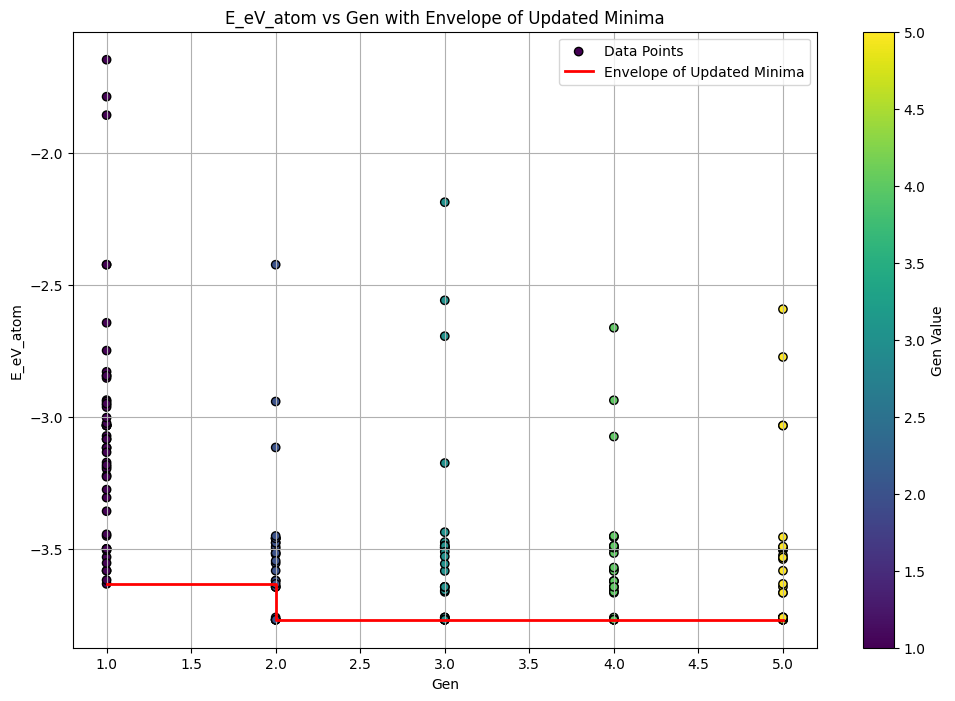

In [7]:
file_path = "./output/data/cryspy_rslt"
# read results as DataFrame format
df = pd.read_csv(file_path, delim_whitespace=True)

# parameter initializaiton
current_min = float('inf')
current_gen = 0

envelope_gen = []
envelope_eV = []

# Loop through the sorted DataFrame to find the envelope points
min_values_by_gen = df.groupby('Gen')['E_eV_atom'].min().reset_index().sort_values('Gen')
for _, row in min_values_by_gen.iterrows():
    if row['E_eV_atom'] < current_min:
        current_min = row['E_eV_atom']
        envelope_gen.append(row['Gen'])
        envelope_eV.append(current_min)
    else:
        envelope_gen.append(row['Gen'])
        envelope_eV.append(current_min)

# plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['Gen'], df['E_eV_atom'], c=df['Gen'], cmap='viridis', edgecolors='k', label='Data Points')
plt.colorbar(scatter, label='Gen Value')

plt.step(envelope_gen, envelope_eV, color='r', where='post', linewidth=2, label='Envelope of Updated Minima')

os.makedirs("./output/fig", exist_ok = True)
plt.xlabel('Gen')
plt.ylabel('E_eV_atom')
plt.title('E_eV_atom vs Gen with Envelope of Updated Minima')
plt.legend()
plt.grid(True)
plt.savefig("./output/fig/E_eV_atom_vs_Gen_with_Envelope.png")
plt.show()

### 5. Verification of Stable Structures

We'll verify if the stable structure matches the experimental structure, which has a Cmcm space group. The space group of the obtained stable structure is the same as the correct structure, which is Cmcm.

In [8]:
df_sorted = df.sort_values(by='E_eV_atom')
df_sorted.head(10)

,Gen,Spg_num,Spg_sym,Spg_num_opt,Spg_sym_opt,E_eV_atom,Magmom,Opt
148,5,1,P1,63,Cmcm,-3.767509,NaN,no_file
103,3,2,P-1,63,Cmcm,-3.767508,NaN,no_file
127,4,6,Pm,63,Cmcm,-3.767508,NaN,no_file
155,5,6,Pm,63,Cmcm,-3.767508,NaN,no_file
84,3,1,P1,63,Cmcm,-3.767507,NaN,no_file
55,2,1,P1,63,Cmcm,-3.767506,NaN,no_file
74,2,10,P2/m,63,Cmcm,-3.767506,NaN,no_file
87,3,11,P2_1/m,63,Cmcm,-3.767506,NaN,no_file
50,2,1,P1,63,Cmcm,-3.767505,NaN,no_file
104,3,12,C2/m,63,Cmcm,-3.767504,NaN,no_file


We will calculate the RDF (Radial Distribution Function) to compare structures. It can be confirmed that the RDF of the structure generated this time almost matches the structure registered in the Materials Project (only the top 3 stable structures and related files are saved in Matlantis-Contrib). Finally, the stable structures are saved as a CIF file.

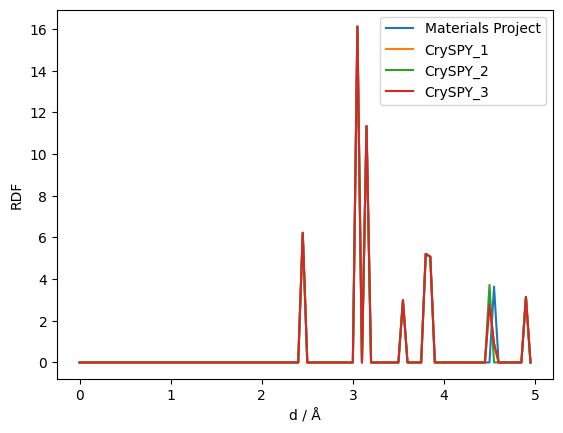

In [9]:
# Materials Project登録データをAtomsオブジェクトとして取得
atoms = read("./input/cif/CaSi.cif")
atoms.set_constraint([FixSymmetry(atoms)])
opt = LBFGSASEOptFeature(filter=True,
                         estimator_fn = pfp_estimator_fn(
                             model_version="v5.0.0",
                             calc_mode=EstimatorCalcMode.CRYSTAL_U0,
                         ),
                        )
result_opt = opt(atoms)
result_opt.atoms.ase_atoms.set_constraint()

# 上位3構造を取得
stable_index = df_sorted.index[:3]
atoms_list = [result_opt.atoms.ase_atoms]
for idx in stable_index:
    file_path = f"./output/work/fin/{str(idx).zfill(6)}/CONTCAR"
    atoms_list.append(read(file_path))

# RDFのプロット
rmax = 5
nbins = 100
delta = [(rmax/nbins)*i for i in range(nbins)]
for n, atoms in enumerate(atoms_list):
    atoms *= (5,5,5)
    ana = Analysis(atoms)
    rdf = ana.get_rdf(rmax,nbins,elements=["Ca","Si"])[0]
    if n == 0:
        plt.plot(delta, rdf, label="Materials Project")
    else:
        plt.plot(delta, rdf, label=f"CrySPY_{n}")

plt.xlabel("d / Å")
plt.ylabel("RDF")
plt.legend()
plt.show()

# cif形式で保存
os.makedirs("./output/cif", exist_ok = True)
for n, atoms in enumerate(atoms_list):
    if n == 0:
        continue
    else:
        strct = AseAtomsAdaptor.get_structure(atoms)
        cw = CifWriter(strct, symprec=0.01)
        cw.write_file(f"./output/cif/CrySPY_{n}.cif")

### 6. Conclusion and Next Steps

Using PFP for relaxing the structures generated by CSP software allows for much faster calculations than if you were using DFT. This approach can yield the correct structure, as shown in this guide. You can also create a convex hull for multi-element systems by running CSP for various compositions.